# Multigraphes orientés et pondérés par le temps

On utilisera la bibliothèque networkx comme structure de donnée adaptée pour les graphes et multigraphes orientés et pondérés.

In [33]:
import time
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

## Fonctions usuelles sur les graphes

In [3]:
def createGraphFromFile(filename):
    "reads textfile and creates the corresponding directed multigraph"

    G = nx.MultiDiGraph()
    
    with open(filename, encoding='utf8') as f:
        for line in f: 
            if line[0] == 's':
                G.add_node(int(line[7]))
            if line[0] == 'a':
                u,v,t,l = line[7], line[9], line[11], line[13]
                G.add_edge(int(u), int(v), date=int(t), duration=int(l))
    return G

In [4]:
MG = createGraphFromFile("graphe.txt")

In [5]:
# Display agencies 
for k in MG.edges(data=True) :
    print(k)

(1, 2, {'date': 1, 'duration': 1})
(1, 2, {'date': 2, 'duration': 1})
(1, 3, {'date': 2, 'duration': 1})
(1, 3, {'date': 4, 'duration': 1})
(2, 4, {'date': 5, 'duration': 1})
(3, 4, {'date': 6, 'duration': 1})
(3, 5, {'date': 7, 'duration': 1})


In [6]:
def createGraphFromMultiGraph(MG):
    G = nx.DiGraph()
    
    # Adding vertices
    for s in MG.nodes():
        for u,v,attribute in MG.edges(data=True):
            t = attribute['date']
            l = attribute['duration']
            if s == u:
                uOut = (u, t)
                vIn = (v, t+l)
                if uOut not in G.nodes():
                    G.add_node(uOut)
                    G.add_edge(uOut, vIn, weight=l)
                if vIn not in G.nodes():
                    G.add_node(vIn)
                
    # Adding 0 weighted edges
    verticesList = list(G.nodes)
    verticesList = sorted(verticesList, key=lambda item: (item[0], item[1]))
    for i in range(len(verticesList)-1):
        if verticesList[i][0] == verticesList[i+1][0]:
            G.add_edge(verticesList[i], verticesList[i+1], weight=0)
    return G

In [7]:
G = createGraphFromMultiGraph(MG)

In [8]:
print(G.edges(data=True))

[((1, 1), (2, 2), {'weight': 1}), ((1, 1), (1, 2), {'weight': 0}), ((2, 2), (2, 3), {'weight': 0}), ((1, 2), (2, 3), {'weight': 1}), ((1, 2), (1, 4), {'weight': 0}), ((2, 3), (2, 5), {'weight': 0}), ((3, 3), (3, 5), {'weight': 0}), ((1, 4), (3, 5), {'weight': 1}), ((3, 5), (3, 6), {'weight': 0}), ((2, 5), (4, 6), {'weight': 1}), ((4, 6), (4, 7), {'weight': 0}), ((3, 6), (4, 7), {'weight': 1}), ((3, 6), (3, 7), {'weight': 0}), ((3, 7), (5, 8), {'weight': 1})]


In [61]:
def createMultiGraph(vertexNumber, probability, duration):
    """generate a directed multigraph given a number of vertices 
    and probability of edge apparition and a fixed duration"""
    
    G = nx.MultiDiGraph()
    
    # Vertices
    for i in range(1, vertexNumber+1):
        G.add_node(i)
    
    for i in range(1, vertexNumber+1):
        dateDep = i
        for j in range(i+1, i+3):
            if len(G.nodes()) <= j:
                break
            dateArr = dateDep + j 
            p = random.uniform(0, 1)
            if p <= probability:
                G.add_edge(i, j, date = dateArr, duration=duration)
    return G

In [49]:
MGAuto = createMultiGraph(2,1,1)

1
2


In [50]:
for v in MGAuto.nodes:
    print(v)
for e in MGAuto.edges(data=True):
    print(e)

1
2


Pour la suite, on va devoir accéder rapidement aux sommets selon les dates de départ ou d'arrivée, on propose ici de trier la liste (on le fera une seule fois par graphe) en un dictionnaire qui regroupe les sommets de issus du même sommet de MG triés par ordre croissant:

In [13]:
def sortVertices(G):
    vertices = dict()
    for v,t in G.nodes():
        if v not in vertices:
            vertices[v] = [(v,t)]
        else:
            vertices[v].append((v,t))
    for v in vertices:
        vertices[v].sort(key=lambda x:x[1])
    return vertices

In [14]:
vertices = sortVertices(G)
print(vertices)

{1: [(1, 1), (1, 2), (1, 4)], 2: [(2, 2), (2, 3), (2, 5)], 3: [(3, 3), (3, 5), (3, 6), (3, 7)], 4: [(4, 6), (4, 7)], 5: [(5, 8)]}


## Algorithmes

On testera la validité de nos algorithmes sur l'instance fournie par le fichier qui correspond au multigraphe fourni dans l'énoncé et généré ci-dessus.

![graphe de test](./graphe.jpg)

### I Chemin d'arrivée au plus tôt

Le but est ici de chercher un chemin partant d'un des sommets de départ (par défaut, celui ayant la plus petite date de départ, il est relié à tous les autres) et le reliant au sommet d'arrivé ayant la plus petite date.
Pour éviter de parcourir plusieurs fois le graphe, on notera tous les sommets correspondant au sommet d'arrivée parcourus et on prendra le meilleur, s'il y en a au moins un.

On utilisera le parcours en profondeur pour chercher un chemin, s'il existe, entre le sommet de départ et le sommet d'arrivée.

In [17]:
def backwardBfs(G, arrival):
    reach = deque()
    reach.append(arrival)
    visited = set()
    visited.add(arrival)
    successors = dict()
    successors[arrival] = (-1,-1)
    
    while reach:
        arrival = reach.pop()
        for v in G.predecessors(arrival):
            if (v) not in visited:
                visited.add(v)
                successors[v] = arrival
                reach.append(v)
    return successors

In [18]:
def backwardBuildPath(successors, v, arrival):
    path = [v]
    a,t = successors[v]
    if a == -1:
        return ([v[0], v[0]], v[1], arrival[1])
    
    while a != arrival[0] and a != -1:
        path += [(a,t)] 
        a,t = successors[(a,t)]
    path += [(a,t)]
    path = list(set([u[0] for u in path]))
    return (path, v[1], arrival[1])

In [19]:
def earliestArrivalPath(G, departure, arrival, vertices):
    G = G.copy()
    i = 0
    while i < len(vertices[arrival]):
        arr = vertices[arrival][i]
        successors = backwardBfs(G, arr)
        for v in vertices[departure]:
            if v in successors:
                return backwardBuildPath(successors, v,arr)
        i+=1
        for v in successors:
            if v[0] != departure and v[0] != arrival:
                G.remove_node(v)
    # We found no path
    return None

In [20]:
# Test
print(earliestArrivalPath(G,1,2, vertices))
print(earliestArrivalPath(G,1,4, vertices))
print(earliestArrivalPath(G,1,1, vertices))
print(earliestArrivalPath(G,2,5, vertices))
print(earliestArrivalPath(G,3,5, vertices))

([1, 2], 1, 2)
([1, 2, 4], 1, 6)
([1, 1], 1, 1)
None
([3, 5], 3, 8)


Les résultats se lisent de la façon suivante :  
* Le chemin d'arrivée au plus tôt de 1 à 2 commence à la date 1, finit à la date 2, a donc une durée 1 et une distance de 1 
* Le chemin d'arrivée au plus tôt de 1 à 4 commence à la date 1, finit à la date 6, a une durée de 5 et a une distance de 3. 
* Si le tuple retourné contient des -1, alors il n'existe pas de chemin

### II Chemin de départ au plus tard

On prend le dernier sommet de départ, et on parcours le graphe :
Soit on trouve un des sommets d'arrivée avant la date limite
Soit on régresse dans les sommets de départs et on recommence

In [21]:
def bfs(G, departure):
    reach = deque()
    reach.append(departure)
    visited = set()
    visited.add(departure)
    predecessors = dict()
    predecessors[departure] = (-1,-1)
    
    while reach:
        departure = reach.pop()
        for v in G.successors(departure):
            if (v) not in visited:
                visited.add(v)
                predecessors[v] = departure
                reach.append(v)
    return predecessors

In [22]:
def buildPath(predecessors, v, dep):
    path = [v]
    a,t = predecessors[v]
    if a == -1:
        return ([dep[0], dep[0]], dep[1], v[1])
    
    while a != dep[0] and a != -1:
        path = [(a,t)] + path
        a,t = predecessors[(a,t)]
    path = [(a,t)] + path
    path = list(set([u[0] for u in path]))
    return (path, dep[1], v[1])

In [24]:
def latestDeparturePath(G, departure, arrival, vertices, arrivalDate):
    G = G.copy()
    i = 1
    while i <= len(vertices[departure]):
        dep = vertices[departure][-i]
        predecessors = bfs(G, dep)
        for v in vertices[arrival]:
            
            if v in predecessors and v[1] < arrivalDate:
                return buildPath(predecessors, v, dep)
        for v in predecessors:
            if v[0] != departure and v[0] != arrival:
                G.remove_node(v)
            
        i+=1
    # We found no path
    return None

In [25]:
# Test
print(latestDeparturePath(G,1,2,vertices,4))
print(latestDeparturePath(G,1,2,vertices,3))
print(latestDeparturePath(G,1,4,vertices,8))
print(latestDeparturePath(G,1,4,vertices,7))

([1, 2], 2, 3)
([1, 2], 1, 2)
([1, 3, 4], 4, 7)
([1, 2, 4], 2, 6)


### III Chemin le plus rapide

Par définition, le chemin le plus rapide est une combinaison de contraintes des deux chemins précédents. On construit pour aller vite la liste triée par ordre croissant des couples de sommets de départ et d'arrivée selon la durée qui les sépare. 

In [26]:
def shortestPathVertices(G, departure, arrival):
    "returns a sorted list of best couples of vertices for shortest path"
    verticesCouples = []
    for v,t in G.nodes():
        if v == departure:
            for u,d in G.nodes():
                if u == arrival and d-t >= 0:
                    verticesCouples.append(((v,t), (u,d), d-t))
    verticesCouples.sort(key=lambda x:x[-1])
    return verticesCouples

In [27]:
def fastestPath(G, departure, arrival):
    G = G.copy()
    verticesCouples = shortestPathVertices(G, departure, arrival)
    for v,u,d in verticesCouples:   
        predecessors = bfs(G, v)
        if u in predecessors:
            return buildPath(predecessors, u, v)
        else:
            for n in predecessors:
                if n[0] != departure and n[0] != arrival:
                    G.remove_node(n)
    # We found no path
    return None

In [28]:
print(fastestPath(G,1,2))
print(fastestPath(G,1,4))
print(fastestPath(G,1,1))

([1, 2], 1, 2)
([1, 2, 4], 2, 6)
([1, 1], 1, 1)


### IV Plus court chemin
*On utilise Dijkstra*

In [29]:
def buildPathDijkstra(distance, path):
    limit = len(path)
    for i in range(1, len(path)):
        if path[-i][0] == path[-(i+1)][0]:
            limit -= 1
        else:
            break
        
    finalPath = list(set([v[0] for v in path]))
    return (finalPath, path[0][1], path[limit-1][1])

In [30]:
def shortestPath(G, departure, arrival, vertices):
    
    
    # Get the proper departure and arrival vertices in G 
    departure=vertices[departure][0]
    arrival=vertices[arrival][-1]
    
    # error detection
    if departure == -1 or arrival == -1:
        err = f"Either departure {departure} or arrival {arrival} is not in G"
        raise nx.NodeNotFound(err)
    
    v1,d1 = departure
    v2,d2 = arrival

    if v1 == v2:
        return (buildPathDijkstra(0, [departure]))
    
    dist = dict()
    for i in G.nodes():
        dist[i] = (float("Inf"), -1)
    dist[departure] = (0,-1)
    
    # Get distances 
    for u,v,w in G.edges(data='weight'):
        d1, p1 = dist[u]
        d2, p2 = dist[v]
        if d1 != float("Inf") and d1+w < d2:
            dist[v] = (d1+w, u)
    
    d,p = dist[arrival]
    if d == float("Inf"):
        return None
    
    distance = d
    # Get path
    v = arrival
    path = [v]
    while v != departure:
        d, p = dist[v] 
        path = [p] + path
        v = p
        
    return buildPathDijkstra(distance, path)

In [31]:
# Tests
print(shortestPath(G, 1, 4, vertices))

([1, 2, 4], 1, 6)


## Tests

##### Temps d'exécution en fonction du nombre de sommets

On fixe la probabilité d'apparition des arcs à 1 pour s'assurer que le nombre d'arcs augmente linéairement en fonction du nombre de sommets.  
Et pour n s'incrémentant, on crée un multigraphe et on applique les quatre algorithmes pour obtenir leur temps d'exécution. 

In [147]:
# fixed parameters
p = 1
l = 1
n = 100
repeat = 10

resultTime1 = np.zeros(n)
resultTime2 = np.zeros(n)
resultTime3 = np.zeros(n)
resultTime4 = np.zeros(n)
verticeNumber = np.zeros(n)

In [148]:
# Harvest results
for j in range(repeat):
    for i in range(1,n+1,1):
        verticeNumber[i-1] = i
        # MG & G generation
        MGtest = createMultiGraph(i, p, l)
        Gtest = createGraphFromMultiGraph(MGtest) 
        nodes = list(MG.nodes())


        # Algorithms
        t0 = time.time()
        sortedVertices = sortVertices(Gtest)
        sortingTime = time.time() - t0

        if sortedVertices == {}:
            continue
        # 1
        t1 = time.time()
        earliestArrivalPath(Gtest, sortedVertices[1][0][0], sortedVertices[i-1][0][0], sortedVertices)
        resultTime1[i-1] += time.time() - t1  + sortingTime

        # 2
        t2 = time.time()
        latestDeparturePath(Gtest,sortedVertices[1][0][0], sortedVertices[i-1][0][0], sortedVertices, i*10)
        resultTime2[i-1] += time.time() - t2  + sortingTime

        # 3
        t3 = time.time()
        fastestPath(Gtest,sortedVertices[1][0][0], sortedVertices[i-1][0][0])
        resultTime3[i-1] += time.time() - t3  + sortingTime
        # 4
        t4 = time.time()
        shortestPath(Gtest, sortedVertices[1][0][0], sortedVertices[i-1][0][0], sortedVertices)
        resultTime4[i-1] += time.time() - t4 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [149]:
resultTime1 /= repeat
resultTime2 /= repeat
resultTime3 /= repeat
resultTime4 /= repeat

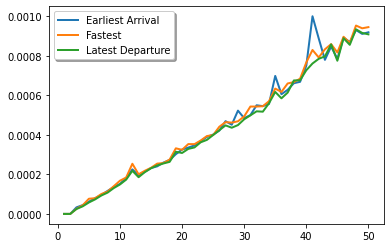

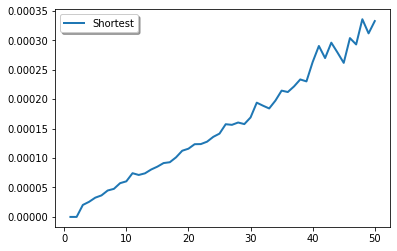

In [157]:
# Display results
fig, ax = plt.subplots()
l1 = ax.plot(verticeNumber, resultTime1, linewidth=2.0, label='Earliest Arrival')
l3 = ax.plot(verticeNumber, resultTime3, linewidth=2.0, label='Fastest')
l2 = ax.plot(verticeNumber, resultTime2, linewidth=2.0, label='Latest Departure')
legend = ax.legend(loc='upper left', shadow=True)
plt.show()


fig, ax = plt.subplots()
l4 = ax.plot(verticeNumber, resultTime4, linewidth=2.0, label='Shortest')
legend = ax.legend(loc='upper left', shadow=True)
plt.show()

/tmp/ipykernel_3765/1908504964.py:2: RuntimeWarning: divide by zero encountered in log
  logres1 = np.log(resultTime1)
/tmp/ipykernel_3765/1908504964.py:3: RuntimeWarning: divide by zero encountered in log
  logres2 = np.log(resultTime2)
/tmp/ipykernel_3765/1908504964.py:4: RuntimeWarning: divide by zero encountered in log
  logres3 = np.log(resultTime3)
/tmp/ipykernel_3765/1908504964.py:5: RuntimeWarning: divide by zero encountered in log
  logres4 = np.log(resultTime4)


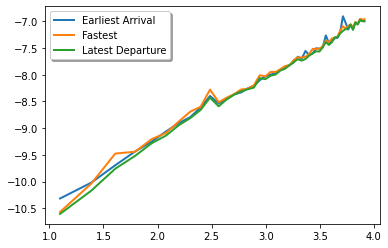

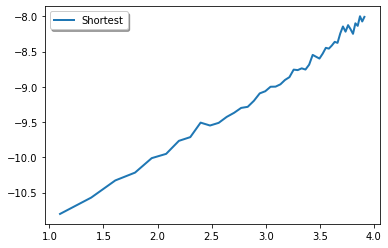

In [158]:
logvertice = np.log(verticeNumber)
logres1 = np.log(resultTime1)
logres2 = np.log(resultTime2)
logres3 = np.log(resultTime3)
logres4 = np.log(resultTime4)


fig, ax = plt.subplots()
l1 = ax.plot(logvertice, logres1, linewidth=2.0, label='Earliest Arrival')
l3 = ax.plot(logvertice, logres3, linewidth=2.0, label='Fastest')
l2 = ax.plot(logvertice, logres2, linewidth=2.0, label='Latest Departure')
legend = ax.legend(loc='upper left', shadow=True)
plt.show()


fig, ax = plt.subplots()
l4 = ax.plot(logvertice, logres4, linewidth=2.0, label='Shortest')
legend = ax.legend(loc='upper left', shadow=True)
plt.show()

##### Temps d'exécution en fonction de la probabilité d'apparition des arètes

On fixe le nombre de sommets à 50 et on fait varier p de 0.1 à 1

In [176]:
# fixed parameters
v = 50
l = 1

repeat = 100
n = 10
resultTime1 = np.zeros(n)
resultTime2 = np.zeros(n)
resultTime3 = np.zeros(n)
resultTime4 = np.zeros(n)
verticeNumber = np.zeros(n)

In [177]:
# Harvest results
for j in range(repeat):
    for i in range(1,11,1):
        p = i//10
        verticeNumber[i-1] = p
        # MG & G generation
        MGtest = createMultiGraph(v, p, l)
        Gtest = createGraphFromMultiGraph(MGtest) 
        nodes = list(MG.nodes())


        # Algorithms
        t0 = time.time()
        sortedVertices = sortVertices(Gtest)
        sortingTime = time.time() - t0

        if sortedVertices == {}:
            continue
        # 1
        t1 = time.time()
        earliestArrivalPath(Gtest, sortedVertices[1][0][0], sortedVertices[v-1][0][0], sortedVertices)
        resultTime1[i-1] += time.time() - t1  + sortingTime

        # 2
        t2 = time.time()
        latestDeparturePath(Gtest,sortedVertices[1][0][0], sortedVertices[v-1][0][0], sortedVertices, v*10)
        resultTime2[i-1] += time.time() - t2  + sortingTime

        # 3
        t3 = time.time()
        fastestPath(Gtest,sortedVertices[1][0][0], sortedVertices[v-1][0][0])
        resultTime3[i-1] += time.time() - t3  + sortingTime
        # 4
        t4 = time.time()
        shortestPath(Gtest, sortedVertices[1][0][0], sortedVertices[v-1][0][0], sortedVertices)
        resultTime4[i-1] += time.time() - t4 

In [178]:
resultTime1 /= repeat
resultTime2 /= repeat
resultTime3 /= repeat
resultTime4 /= repeat

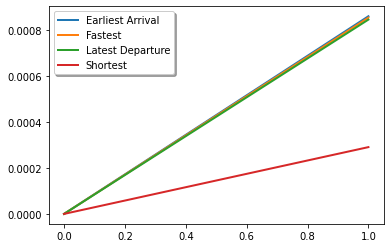

In [179]:
# Display results
fig, ax = plt.subplots()
l1 = ax.plot(verticeNumber, resultTime1, linewidth=2.0, label='Earliest Arrival')
l3 = ax.plot(verticeNumber, resultTime3, linewidth=2.0, label='Fastest')
l2 = ax.plot(verticeNumber, resultTime2, linewidth=2.0, label='Latest Departure')
l4 = ax.plot(verticeNumber, resultTime4, linewidth=2.0, label='Shortest')
legend = ax.legend(loc='upper left', shadow=True)
plt.show()

##### Temps d'exécution en fonction de la durée des trajets

Théoriquement, la durée des trajets n'influe pas sur la complexité de nos quatre algorithmes.

In [203]:
# fixed parameters
v = 20
p = 1

n = 20
repeat = 50

resultTime1 = np.zeros(n-4)
resultTime2 = np.zeros(n-4)
resultTime3 = np.zeros(n-4)
resultTime4 = np.zeros(n-4)
verticeNumber = np.zeros(n-4)

In [205]:
# Harvest results
for j in range(repeat):
    for i in range(5,n+1,1):
        verticeNumber[i-5] = i
        # MG & G generation
        MGtest = createMultiGraph(v, p, i)
        Gtest = createGraphFromMultiGraph(MGtest) 
        nodes = list(MG.nodes())


        # Algorithms
        t0 = time.time()
        sortedVertices = sortVertices(Gtest)
        sortingTime = time.time() - t0

        if sortedVertices == {}:
            continue
        # 1
        t1 = time.time()
        earliestArrivalPath(Gtest, sortedVertices[1][0][0], sortedVertices[v-1][0][0], sortedVertices)
        resultTime1[i-5] += time.time() - t1  + sortingTime

        # 2
        t2 = time.time()
        latestDeparturePath(Gtest,sortedVertices[1][0][0], sortedVertices[v-1][0][0], sortedVertices, v*10)
        resultTime2[i-5] += time.time() - t2  + sortingTime

        # 3
        t3 = time.time()
        fastestPath(Gtest,sortedVertices[1][0][0], sortedVertices[v-1][0][0])
        resultTime3[i-5] += time.time() - t3  + sortingTime
        # 4
        t4 = time.time()
        shortestPath(Gtest, sortedVertices[1][0][0], sortedVertices[v-1][0][0], sortedVertices)
        resultTime4[i-5] += time.time() - t4 

In [206]:
resultTime1 /= repeat
resultTime2 /= repeat
resultTime3 /= repeat
resultTime4 /= repeat

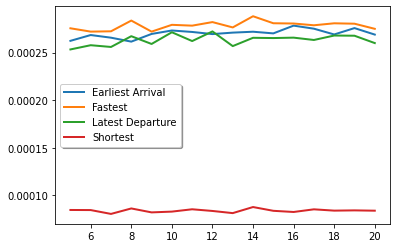

In [208]:
# Display results
fig, ax = plt.subplots()
l1 = ax.plot(verticeNumber, resultTime1, linewidth=2.0, label='Earliest Arrival')
l3 = ax.plot(verticeNumber, resultTime3, linewidth=2.0, label='Fastest')
l2 = ax.plot(verticeNumber, resultTime2, linewidth=2.0, label='Latest Departure')
l4 = ax.plot(verticeNumber, resultTime4, linewidth=2.0, label='Shortest')
legend = ax.legend(loc='center left', shadow=True)
plt.show()